# Integrator validation

In [1]:
# enable plotting in notebook
%matplotlib notebook

The results imported here are results from example simulations which are
stored in another Python file. In real-world usage, the results would
either come from the Python interface of the simulation package, from
flat files containing the results, or from package-specific parsers. See
[SimulationData](../simulation_data.rst)
for more details.

In [2]:
from simulation_results import example_simulations

import physical_validation

The example system consists of 1000 Lennard-Jones (LJ) particles simulated under NVE conditions. To illustrate how the integrator convergence validation can pick up small errors in the simulation, the simulation were repeated with different interaction cutoff schemes. In all cases, the LJ interactions were discarded if the particles were more than 1 nm apart. Uncorrected, this leads to a small discontinuity in the potential and the force at the cutoff distance. A first approach to correct this discontinuity is by shifting the potential by a constant value such that it reaches 0 at the cutoff distance. This fixes the discontinuity in the potential, but does not alter the forces. A second approach is to smoothly switch off both the forces and the potential such that both reach zero at the cut-off distance.

The integrator validation analyzes the convergence of the fluctuations around the integrator constant of motion. For a symplectic integrator, the fluctuation is expected to be directly proportional to the square of the time step. The `physical_validation` check calculates the fluctuation convergence from multiple simulations with different time steps and validates the expectation.

We will start by analyzing simulations without any cut-off corrections. The example simulations contain five otherwise identical simulations performed at timesteps of 0.004, 0.002, 0.001, 0.0005, and 0.00025 ps, respectively.

We will prepare for the analysis by creating a `SimulationData` object for each of these simulations.

In [3]:
simulation_list = []
for timestep in [0.004, 0.002, 0.001, 0.0005, 0.00025]:
    # Load appropriate simulation from examples
    simulation = example_simulations.get(
        f"1000 Lennard-Jones particles, no cut-off correction, timestep {timestep} ps"
    )
    # Append simulation data object to the list. Since the integrator check only needs knowledge
    # about the time step and the constant of motion, we leave the remaining fields empty.
    simulation_list.append(
        physical_validation.data.SimulationData(
            dt=timestep,
            observables=physical_validation.data.ObservableData(
                constant_of_motion=simulation["constant of motion"]
            ),
        )
    )

We can now pass the list of simulations into the integrator test to check whether the convergence behaves as expected:

-----------------------------------------------------------------
        dt        avg       rmsd      slope         ratio        
                                                  dt^2       rmsd
-----------------------------------------------------------------
     0.004   -4749.12   3.66e-01   2.86e-04         --         --
     0.002   -4749.27   3.72e-01   2.77e-04       4.00       0.99
     0.001   -4749.26   3.34e-01   3.47e-04       4.00       1.11
    0.0005   -4749.23   3.37e-01   3.33e-04       4.00       0.99
   0.00025   -4749.23   3.45e-01   2.54e-04       4.00       0.98
-----------------------------------------------------------------


<IPython.core.display.Javascript object>


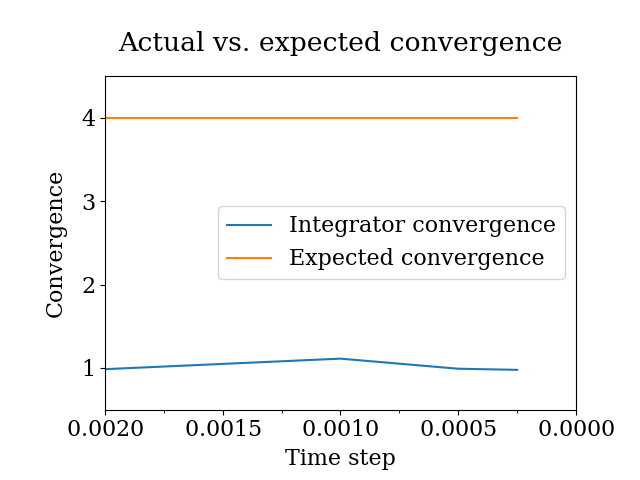

0.7556745974285974

In [4]:
physical_validation.integrator.convergence(simulations=simulation_list, screen=True)

The output of the function consists of the time step, the average value of the constant of motion, and its RMSD during the simulation. The fourth column gives the measured slope of the constant of motion - a large value here would indicate a strong drift and hence a problem in the integrator. Even without strong drift, as in the current situation, a large deviation in the ratio between the RMSD values compared to the ratio between the time step will indicate some error in the integrator. The reason for a failure of this test might not always be intuitively clear, as many components play into the integrator convergence - the integrator algorithm itself, but also the interaction function (e.g. non-continuous cut-off) or the numerical precision of the floating point operations.

In this example, we have introduced the numerical error consciously by not correcting for the LJ cut-off discontinuity. The output makes it clear that there is hardly any time-step dependency of the fluctuation, indicating that the error due to the incorrect cut-off treatment is dominating the fluctuations.

The return value represents the largest deviation from the expected behavior, i.e. the maximum value of `abs(1 - rmsd_ratio / time_step_ratio_squared)`. This allows to evaluate the success of this function programmatically.

We can now compare this to the simulations in which the discontinuity in the potential was corrected by shifting it so that its value at the cut-off reaches zero. Since this is simply an additive constant to the potential, the forces are unchanged. We will again load a set of simulations, and then perform the integrator convergence check.

In [5]:
simulation_list = []
for timestep in [0.004, 0.002, 0.001, 0.0005, 0.00025]:
    # Load appropriate simulation from examples
    simulation = example_simulations.get(
        f"1000 Lennard-Jones particles, potential shift cut-off correction, timestep {timestep} ps"
    )
    # Append simulation data object to the list. Since the integrator check only needs knowledge
    # about the time step and the constant of motion, we leave the remaining fields empty.
    simulation_list.append(
        physical_validation.data.SimulationData(
            dt=timestep,
            observables=physical_validation.data.ObservableData(
                constant_of_motion=simulation["constant of motion"]
            ),
        )
    )

-----------------------------------------------------------------
        dt        avg       rmsd      slope         ratio        
                                                  dt^2       rmsd
-----------------------------------------------------------------
     0.004   -4491.08   1.63e-02  -1.76e-07         --         --
     0.002   -4491.24   4.51e-03  -1.98e-06       4.00       3.62
     0.001   -4491.24   1.36e-03  -2.55e-06       4.00       3.31
    0.0005   -4491.21   2.83e-04  -2.46e-07       4.00       4.81
   0.00025   -4491.19   1.20e-04   2.96e-07       4.00       2.35
-----------------------------------------------------------------


<IPython.core.display.Javascript object>


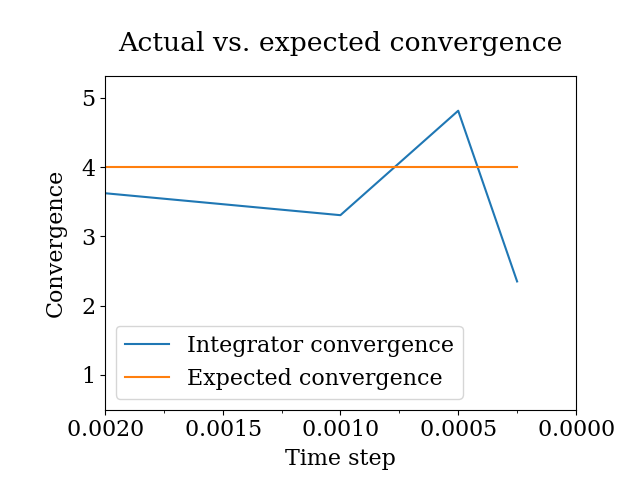

0.41248328620311137

In [6]:
physical_validation.integrator.convergence(simulations=simulation_list, screen=True)

The shifted potential correction does slightly improve the integrator convergence, moving it closer to the expected ratio. When reducing the time step, the error introduced by the non-continuous forces does, however, start to be more dominant, and the decrease of the fluctuations with the time step does not follow expectations anymore.

Finally, we can repeat the analysis using a cut-off correction which smoothly switches both the potential and the forces off.

In [7]:
simulation_list = []
for timestep in [0.004, 0.002, 0.001, 0.0005, 0.00025]:
    # Load appropriate simulation from examples
    simulation = example_simulations.get(
        f"1000 Lennard-Jones particles, potential and force switch cut-off correction, timestep {timestep} ps"
    )
    # Append simulation data object to the list. Since the integrator check only needs knowledge
    # about the time step and the constant of motion, we leave the remaining fields empty.
    simulation_list.append(
        physical_validation.data.SimulationData(
            dt=timestep,
            observables=physical_validation.data.ObservableData(
                constant_of_motion=simulation["constant of motion"]
            ),
        )
    )

-----------------------------------------------------------------
        dt        avg       rmsd      slope         ratio        
                                                  dt^2       rmsd
-----------------------------------------------------------------
     0.004   -4335.09   1.69e-02   5.54e-07         --         --
     0.002   -4335.25   4.37e-03  -4.87e-07       4.00       3.87
     0.001   -4335.24   1.09e-03  -3.81e-08       4.00       4.02
    0.0005   -4335.22   2.77e-04  -2.66e-08       4.00       3.93
   0.00025   -4335.20   6.90e-05  -9.38e-09       4.00       4.02
-----------------------------------------------------------------


<IPython.core.display.Javascript object>


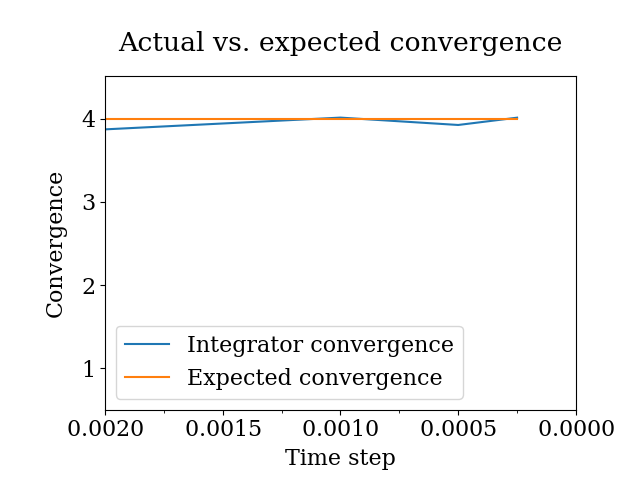

0.03146252406582639

In [8]:
physical_validation.integrator.convergence(simulations=simulation_list, screen=True)

Having now eliminated both sources of numerical artefacts in the integration, the fluctuations do scale with the time step almost exactly as expected. The very low deviations give us confidence that the integrator is operating correctly.